In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

In [2]:
def EulerODE(t, x0, f, *args):
    """
    Solves an ordinary differential equation using the Euler method.

    Args:
        t (np.ndarray): Array of time points (1xT).
        x0 (np.ndarray): Array of initial conditions (Nx1).
        f (callable): Function handle representing the ODE, f(x, *args) returns the derivative of x.
        *args: Additional arguments to be passed to the ODE function f.

    Returns:
        np.ndarray: Array of the solution x with size [N, T].
    """
    T = len(t)
    N = len(x0)
    x = np.zeros((N, T))
    x[:, 0] = x0

    for i in range(T - 1):
        h = t[i + 1] - t[i]
        x[:, i + 1] = x[:, i] + h * f(x[:, i], *args)
    return x


In [3]:
def EulerSDE(t, x0, f, stdnoise, *args):
    """
    Solves a stochastic differential equation using the Euler-Maruyama method.

    Args:
        t (np.ndarray): Array of time points (1xT).
        x0 (np.ndarray): Array of initial conditions (Nx1).
        f (callable): Function handle representing the ODE part of the SDE, f(x, *args).
        stdnoise (np.ndarray): Array of standard deviations of the noise for each dimension (Nx1).
        *args: Additional arguments to be passed to the ODE function f.

    Returns:
        np.ndarray: Array of the solution x with size [N, T].
    """
    T = len(t)
    N = len(x0)
    x = np.zeros((N, T))
    x[:, 0] = x0

    h = np.diff(t)

    for i in range(T - 1):
        dw = np.sqrt(h[i]) * np.random.normal(0, 1, N)
        x[:, i + 1] = x[:, i] + h[i] * f(x[:, i], *args) + stdnoise * dw
    return x

In [4]:
def sigmoid(x, k, theta):
    """Sigmoid activation function."""
    return 1 / (1 + np.exp(-(x - theta) * k))


In [5]:
def WilsonCowan(x, P):
    """
    Implements the Wilson-Cowan model ODEs.

    Args:
        x (np.ndarray): A 2x1 matrix [E; I] representing the firing rates of
                       the excitatory (E) and inhibitory (I) populations.
        P (float): The external input current to the excitatory population.

    Returns:
        np.ndarray: A 2x1 vector [Edot; Idot] representing the derivatives
                    of the excitatory and inhibitory firing rates.
    """
    E = x[0]
    I = x[1]

    # Parameters
    tau_E = 3.2
    tau_I = 3.2
    cEE = 2.4
    cIE = 2
    cEI = 3.2
    cII = 0
    kE = 4
    kI = 4
    thetaE = 1
    thetaI = 1

    # Sigmoid functions
    S_E = sigmoid(E, kE, thetaE)
    S_I = sigmoid(I, kI, thetaI)

    # Derivatives
    Edot = (-E + cEE * S_E - cIE * S_I + P) / tau_E
    Idot = (-I + cEI * S_E - cII * S_I) / tau_I

    return np.array([Edot, Idot])

In [6]:
if __name__ == '__main__':
    # SimulateWilsonCowan.m equivalent in Python with SDE

    # Parameters
    tau_E = 3.2
    tau_I = 3.2
    cEE = 2.4
    cIE = 2
    cEI = 3.2
    cII = 0
    kE = 4
    kI = 4
    thetaE = 1
    thetaI = 1

    # Time span and initial conditions
    t_start = 0
    t_end = 200
    h = 0.1
    t = np.arange(t_start, t_end + h, h)
    x0 = np.array([0.1, 0.1])  # Initial firing rates [E, I]

    # Task 9: Run with zero noise (should be same as EulerODE)
    P = 0
    stdnoise = np.array([0, 0])  # Standard deviation of noise for E and I
    x_sde_no_noise = EulerSDE(t, x0, WilsonCowan, stdnoise, P)

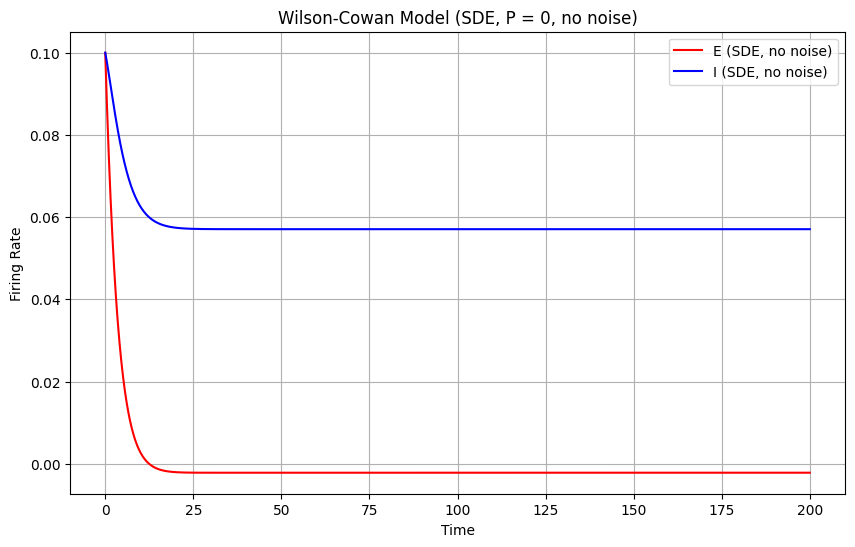

In [8]:
    # Plot the results for P = 0 and no noise
    plt.figure(figsize=(10, 6))
    plt.plot(t, x_sde_no_noise[0, :], 'r-', label='E (SDE, no noise)')
    plt.plot(t, x_sde_no_noise[1, :], 'b-', label='I (SDE, no noise)')
    plt.xlabel('Time')
    plt.ylabel('Firing Rate')
    plt.title(f'Wilson-Cowan Model (SDE, P = {P}, no noise)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [9]:
    print("\nTask 9: With zero noise, the results from EulerSDE should be very similar to those obtained using EulerODE.")


Task 9: With zero noise, the results from EulerSDE should be very similar to those obtained using EulerODE.


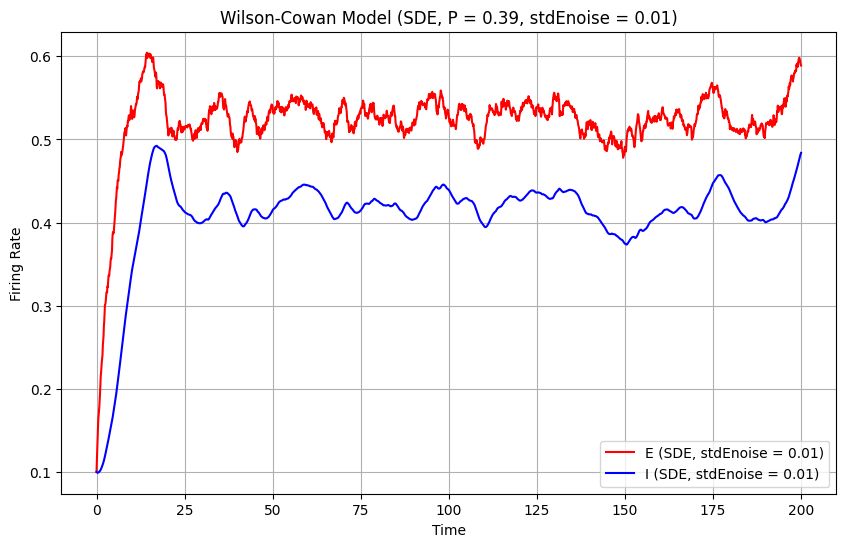

In [10]:
    # Task 10: Set P = 0.39 and introduce noise to E
    P_noise = 0.39
    stdEnoise = 0.01
    stdInoise = 0.00
    stdnoise_with_E = np.array([stdEnoise, stdInoise])
    x_sde_with_noise_E = EulerSDE(t, x0, WilsonCowan, stdnoise_with_E, P_noise)

    # Plot the results for P = 0.39 with noise in E
    plt.figure(figsize=(10, 6))
    plt.plot(t, x_sde_with_noise_E[0, :], 'r-', label=f'E (SDE, stdEnoise = {stdEnoise})')
    plt.plot(t, x_sde_with_noise_E[1, :], 'b-', label=f'I (SDE, stdEnoise = {stdEnoise})')
    plt.xlabel('Time')
    plt.ylabel('Firing Rate')
    plt.title(f'Wilson-Cowan Model (SDE, P = {P_noise}, stdEnoise = {stdEnoise})')
    plt.legend()
    plt.grid(True)
    plt.show()


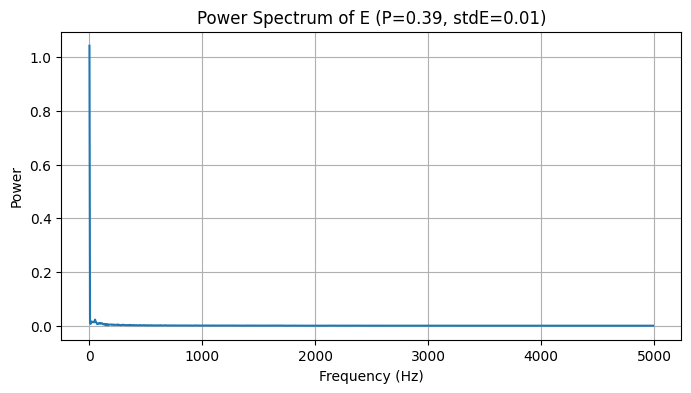


Task 10: With P = 0.39 (steady state) and stdEnoise = 0.01, you should observe oscillations that were not present in the deterministic case. The noise introduces perturbations that can be amplified by the system's dynamics, leading to oscillations.


In [11]:
    # Power spectrum analysis (equivalent to the Matlab code)
    def plot_power_spectrum(time_series, dt, title):
        N = len(time_series)
        yf = fft(time_series)
        xf = fftfreq(N, dt)[:N//2]
        power_spectrum = np.abs(yf[0:N//2]) * 2 / N
        plt.figure(figsize=(8, 4))
        plt.plot(xf, power_spectrum)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power')
        plt.title(title)
        plt.grid(True)
        plt.show()

    plot_power_spectrum(x_sde_with_noise_E[0, :], h / 1000, f'Power Spectrum of E (P={P_noise}, stdE={stdEnoise})') # Convert ms to s for Hz
    print("\nTask 10: With P = 0.39 (steady state) and stdEnoise = 0.01, you should observe oscillations that were not present in the deterministic case. The noise introduces perturbations that can be amplified by the system's dynamics, leading to oscillations.")


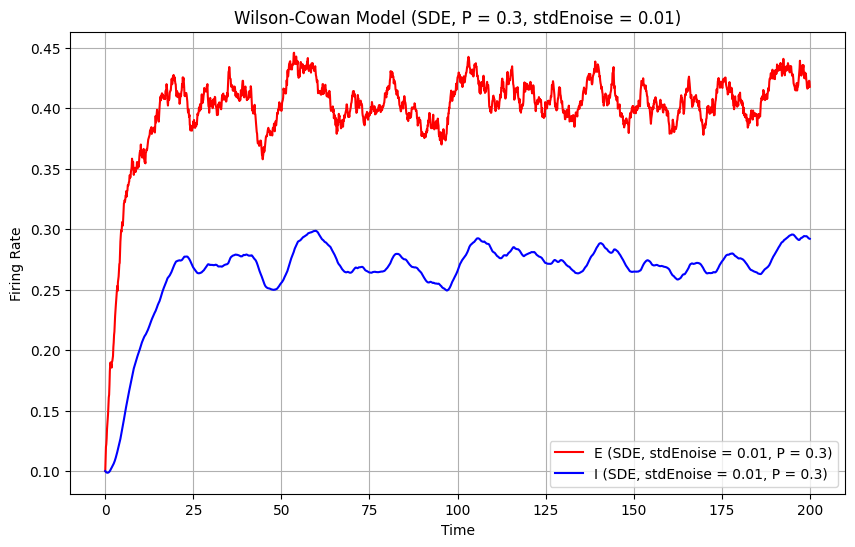

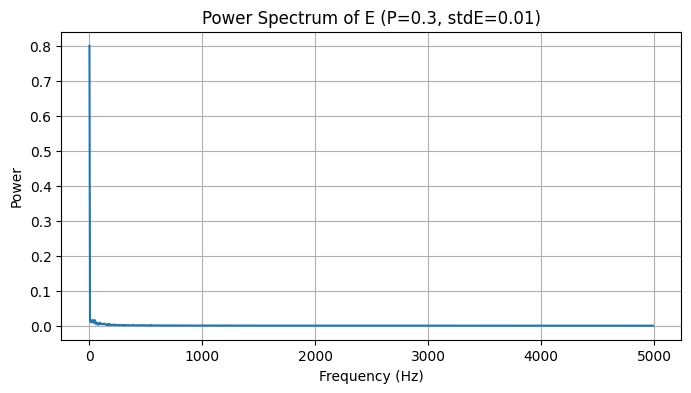


As you decrease P, the amplitude and frequency of the noise-induced oscillations might change. The underlying deterministic dynamics of the system (which are influenced by P) shape how the noise is filtered and amplified. For values of P closer to a bifurcation point (where the system transitions from a steady state to an oscillatory state in the deterministic case), the noise is more likely to drive oscillations.

Why these results?
The noise acts as a continuous source of small perturbations to the system's state. When the deterministic system is near a stable steady state (like at P = 0.39), these perturbations are usually damped out. However, if the system's dynamics are such that there's an underlying tendency towards oscillation (even if it's not fully expressed at that specific parameter value), the noise can 'kick' the system away from the steady state in a way that triggers oscillatory behavior. The frequency of these noise-induced oscillations is often related to the charact

In [12]:
    # Check if the oscillation is in the gamma range (30-100 Hz) by looking at the power spectrum.

    # Explore decreasing P
    P_lower = 0.3
    stdnoise_with_E_lower = np.array([stdEnoise, stdInoise])
    x_sde_with_noise_E_lower = EulerSDE(t, x0, WilsonCowan, stdnoise_with_E_lower, P_lower)

    plt.figure(figsize=(10, 6))
    plt.plot(t, x_sde_with_noise_E_lower[0, :], 'r-', label=f'E (SDE, stdEnoise = {stdEnoise}, P = {P_lower})')
    plt.plot(t, x_sde_with_noise_E_lower[1, :], 'b-', label=f'I (SDE, stdEnoise = {stdEnoise}, P = {P_lower})')
    plt.xlabel('Time')
    plt.ylabel('Firing Rate')
    plt.title(f'Wilson-Cowan Model (SDE, P = {P_lower}, stdEnoise = {stdEnoise})')
    plt.legend()
    plt.grid(True)
    plt.show()
    plot_power_spectrum(x_sde_with_noise_E_lower[0, :], h / 1000, f'Power Spectrum of E (P={P_lower}, stdE={stdEnoise})')

    print("\nAs you decrease P, the amplitude and frequency of the noise-induced oscillations might change. The underlying deterministic dynamics of the system (which are influenced by P) shape how the noise is filtered and amplified. For values of P closer to a bifurcation point (where the system transitions from a steady state to an oscillatory state in the deterministic case), the noise is more likely to drive oscillations.")

    print("\nWhy these results?")
    print("The noise acts as a continuous source of small perturbations to the system's state. When the deterministic system is near a stable steady state (like at P = 0.39), these perturbations are usually damped out. However, if the system's dynamics are such that there's an underlying tendency towards oscillation (even if it's not fully expressed at that specific parameter value), the noise can 'kick' the system away from the steady state in a way that triggers oscillatory behavior. The frequency of these noise-induced oscillations is often related to the characteristic frequencies of the underlying system dynamics.")
    print("Decreasing P can move the system closer to or further away from such a 'latent' oscillatory regime, thus affecting the characteristics of the noise-induced oscillations.")
